In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [3]:
from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import re
import torch
from typing import Union, Callable
from tqdm.auto import tqdm

from src.utils import concat_csv_with_indices

In [9]:
sns.set_context("talk", font_scale=1.5)

In [4]:
state_space_spec_path = "outputs/state_space_specs/librispeech-train-clean-100/w2v2_8/state_space_specs.pkl"



In [5]:
predictions_df = concat_csv_with_indices("outputs/word_recognition/librispeech-train-clean-100/**/predictions-frame_*.csv",
                        [re.compile(r"frame_(\d+)\.csv"),
                         lambda p: p.parents[2].name,
                         lambda p: p.parents[3].name, lambda p: p.parents[4].name,
                         lambda p: p.parents[5].name],
                        ["frame_idx",
                         "equivalence", "model", "base_model", "dataset"
                          ]).reset_index()

predictions_df["frame_idx"] = predictions_df.frame_idx.astype(int)

predictions_df["trace"] = predictions_df.base_model + "/" + predictions_df.model + "/" + predictions_df.equivalence

In [27]:
plot_traces = {
    "Word": "w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "Random": "w2v2_8/randomrnn_32/random",
    "Phoneme": "w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
}
plot_max_num_frames = 9
predictions_df = predictions_df[predictions_df.trace.isin(plot_traces.values())]
predictions_df["Trace"] = predictions_df.trace.map({v: k for k, v in plot_traces.items()})
predictions_df["# phonemes seen"] = predictions_df.frame_idx + 1

In [11]:
# estimate chance performance for word recognition at each dataset + frame
chance_performance = {}
for dataset, dataset_results in predictions_df.groupby("dataset"):
    # take any trace; they're all the same
    chance_df = next(iter(dataset_results.groupby("trace")))[1]
    # # words should all be balanced in this evaluaton, so we can take the mean of relative word frequency
    # words may not be balanced; take the max-probability word assuming random guessing
    chance_performance[dataset] = chance_df.groupby("frame_idx").apply(lambda x: x.label.value_counts(normalize=True).max()).rename("chance_performance")
chance_performance = pd.concat(chance_performance, names=["dataset"])
chance_performance

/tmp/ipykernel_1627941/1779887723.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chance_performance[dataset] = chance_df.groupby("frame_idx").apply(lambda x: x.label.value_counts(normalize=True).max()).rename("chance_performance")


dataset                      frame_idx
librispeech-train-clean-100  0            0.000195
                             1            0.000195
                             2            0.000201
                             3            0.000235
                             4            0.000305
                             5            0.000441
                             6            0.000697
                             7            0.001190
                             8            0.002205
                             9            0.004537
                             10           0.009673
                             11           0.024190
                             12           0.068027
                             13           0.126506
                             14           0.346154
                             15           0.666667
Name: chance_performance, dtype: float64

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


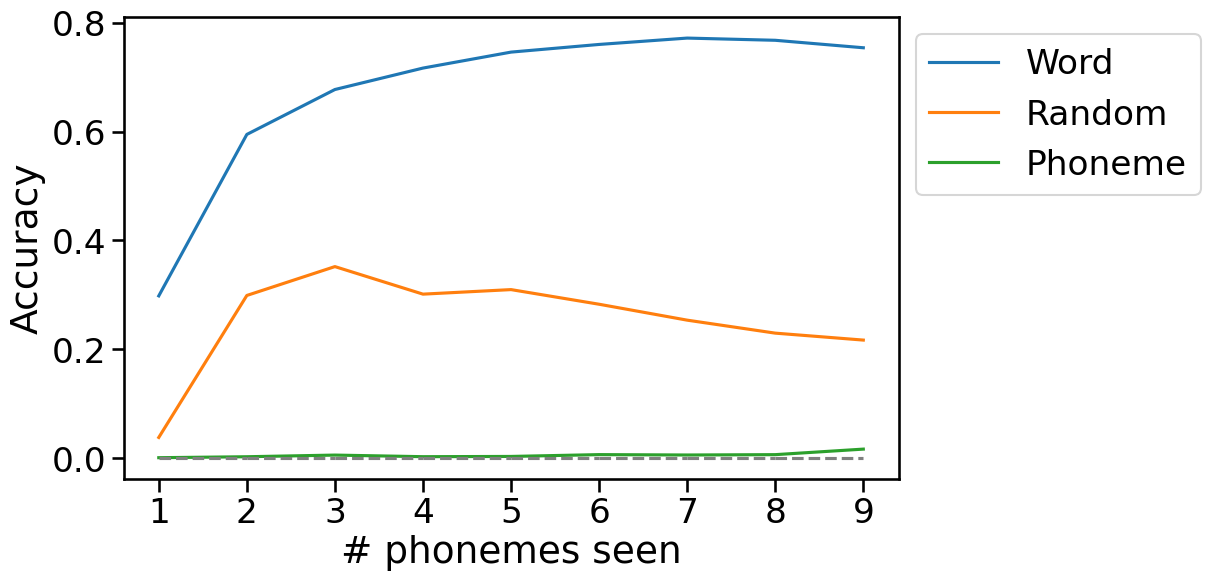

In [32]:
acc_df = predictions_df.loc[(predictions_df.dataset == plot_dataset)] \
    .groupby(["Trace", "# phonemes seen"]).correct.mean().reset_index()
hue_order = acc_df.groupby("Trace").correct.mean().sort_values(ascending=False).index

acc_df = acc_df[acc_df["# phonemes seen"] <= plot_max_num_frames]

f, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(data=acc_df,
                  x="# phonemes seen", y="correct", hue="Trace", hue_order=hue_order,
                  ax=ax)
ax.set_xticks(range(1, plot_max_num_frames + 1))

ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("# phonemes seen")
ax.set_ylabel("Accuracy")

# draw chance performance as a horizontal line over each x value
for frame, frame_chance_perf in chance_performance.loc[plot_dataset].items():
    if frame + 2 > plot_max_num_frames:
        continue
    ax.plot([frame + 1, frame + 2], [frame_chance_perf, frame_chance_perf],
            color="gray", linestyle="--")

In [55]:
acc_df.groupby(["Trace"]).correct.max()

Trace
Phoneme    0.016671
Random     0.351896
Word       0.771609
Name: correct, dtype: float64

## Frequency effects in recognition

In [20]:
word_freq_df = pd.read_csv("data/SUBTLEXus74286wordstextversion.txt", sep="\t", index_col=0)

In [21]:
num_frequency_bins = 6
word_freq_df["log_frequency_bin"] = pd.qcut(word_freq_df.Lg10WF, num_frequency_bins, labels=list(range(num_frequency_bins - 1)), duplicates="drop").astype(int)

In [35]:
predictions_df_meta = pd.merge(predictions_df, word_freq_df, left_on="label", right_index=True)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

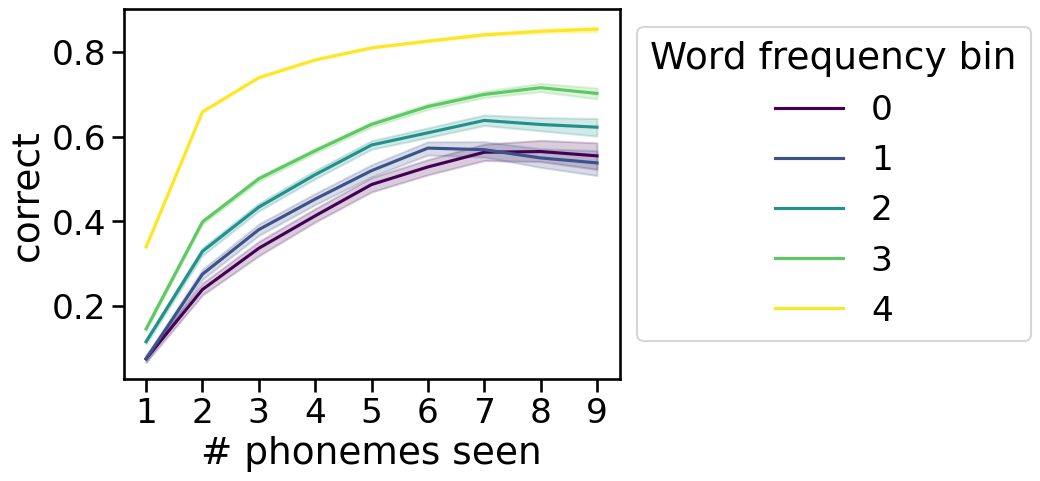

In [54]:
ax = sns.lineplot(data=predictions_df_meta[(predictions_df_meta.Trace == "Word") &
                                           (predictions_df_meta["# phonemes seen"] <= plot_max_num_frames)],
                  x="# phonemes seen", y="correct", hue="log_frequency_bin", palette="viridis")
ax.set_xticks(range(1, plot_max_num_frames + 1))
ax.legend(title="Word frequency bin", loc="upper left", bbox_to_anchor=(1, 1))

## Accuracy distribution between words

In [60]:
accuracy_distribution_df = predictions_df_meta \
    .groupby(["Trace", "label", "label_instance_idx", "Lg10WF", "log_frequency_bin"]).correct.max() \
    .groupby(["Trace", "label", "Lg10WF", "log_frequency_bin"]).mean()
accuracy_distribution_df

Trace    label       Lg10WF  log_frequency_bin
Phoneme  a           6.0175  4                    0.000000
         aback       1.2041  2                    0.000000
         abandon     2.6170  4                    0.157895
         abandoned   2.8319  4                    0.000000
         abandoning  1.9395  3                    0.000000
                                                    ...   
Word     zest        1.5563  3                    1.000000
         zigzag      1.3802  2                    1.000000
         zone        3.0116  4                    1.000000
         zoological  0.9542  1                    0.000000
         zoologist   1.1139  2                    1.000000
Name: correct, Length: 47970, dtype: float64

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

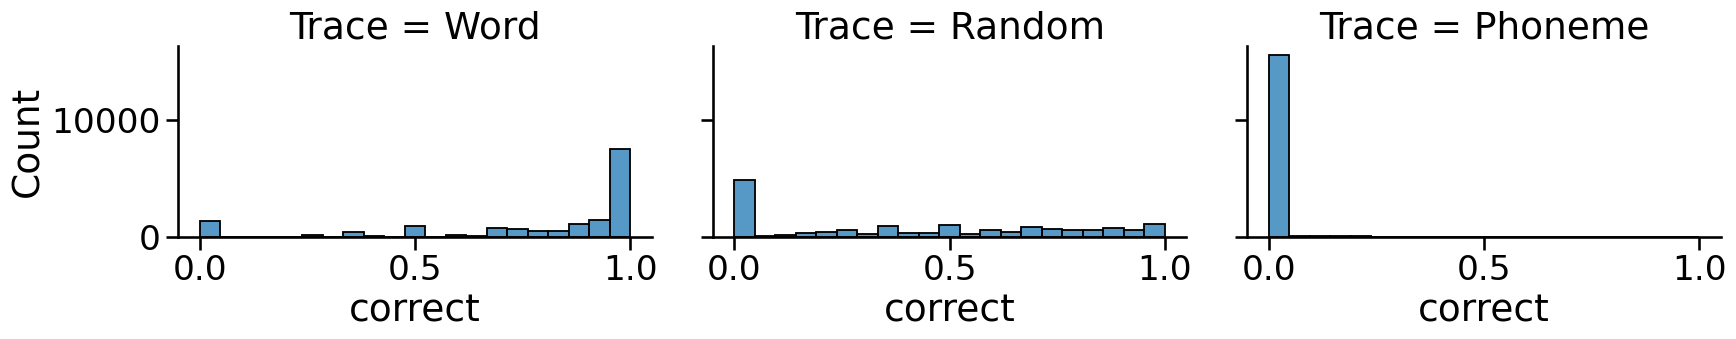

In [61]:
col_order = accuracy_distribution_df.groupby("Trace").mean().sort_values(ascending=False).index
sns.displot(data=accuracy_distribution_df.reset_index(), 
            x="correct", col="Trace", col_order=col_order, col_wrap=3,
            facet_kws=dict(sharex=False), height=4, aspect=1.5)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 76.50000000000001, 'Word frequency bin')

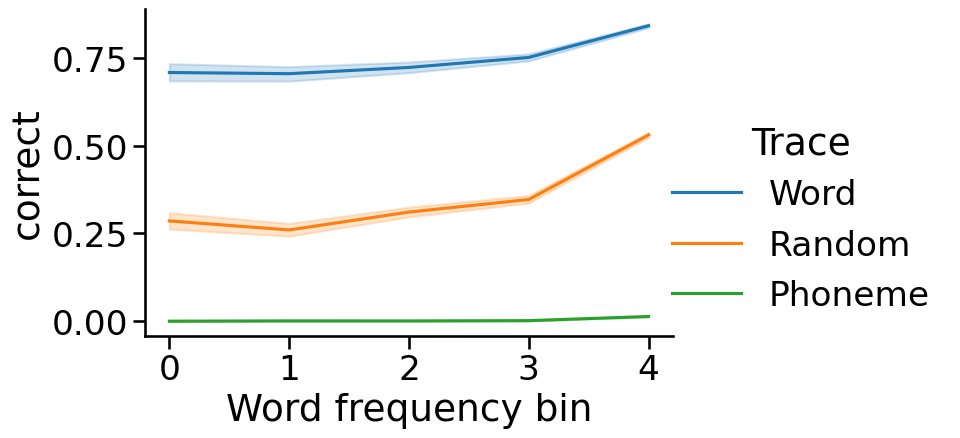

In [64]:
g = sns.relplot(data=accuracy_distribution_df.reset_index(),
            x="log_frequency_bin", y="correct",
            hue="Trace", hue_order=accuracy_distribution_df.groupby("Trace").mean().sort_values(ascending=False).index,
            kind="line", aspect=1.5)
g.axes.flat[0].set_xlabel("Word frequency bin")